This is an exercise to improve the recommender system that we built in our previous exercise.

Few ideas that we will experiment in improving our existing recommendation system are 

* There are probably some outliers in our user rating dataset, what if we were to throw away people that rated some ridiculous number of movies? Maybe they're skewing everything. 
* We can also improve upon the fact that we saw a lot of movies in the results that were similar to Gone with the Wind, even though we didn't like Gone with the Wind. You know we weighted those results lower than similarities to movies that were enjoyed, but maybe those movies should actually be penalized. If I hated Gone with the Wind that much, maybe similarities to Gone with the Wind, like The Wizard of Oz, should actually be penalized and, you know lowered in their score instead of raised at all.
* We used a minimum period value of 100, maybe that's too high, maybe it's too low; we just kind of picked it arbitrarily. What happens if you play with that value? If you were to lower that for example, I would expect you to see some new movies maybe you've never heard of, but might still be a good recommendation for that person. Or, if you were to raise it higher, you would see, you know nothing but blockbusters.

In [1]:
# Importing the data into data frame and merging to make sense of the title names.
import pandas as pd
import numpy as np
r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep='\\t', names=r_cols, usecols=range(3), engine='python')

m_cols = ['movie_id', 'title']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(2), engine='python')

ratings = pd.merge(movies, ratings)

ratings.head()

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3


In [2]:
# Total number of unique users
ratings.user_id.nunique()

944

In [3]:
# Find the total number of unique movies in the list

ratings.title.nunique()

# there 1664 movies in the list.

1664

Here Lets Try to Identify the users who are skewing the rating results by having ridiculous number of movie ratings

In [4]:
# This data frame will give us the user ID and the number of movies rated by them
user_number_of_movies_rated = numberofmovierated = ratings['user_id'].value_counts().to_frame()
user_number_of_movies_rated.reset_index(level=0, inplace=True)
user_number_of_movies_rated = numberofmovierated.rename(columns={"index": "User_Id", "user_id" :"Number_of_Movies_Rated"})
user_number_of_movies_rated.head()

,User_Id,Number_of_Movies_Rated
0,405,737
1,655,685
2,13,636
3,450,540
4,276,518


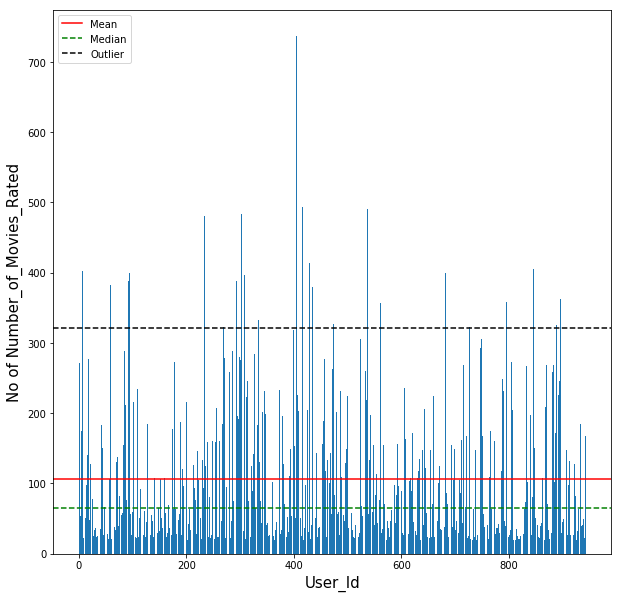

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
Index = user_number_of_movies_rated['User_Id']
Values = user_number_of_movies_rated['Number_of_Movies_Rated']
plt.xlabel('User_Id', fontsize=15)
plt.ylabel('No of Number_of_Movies_Rated', fontsize=15)
plt.axhline(y=user_number_of_movies_rated['Number_of_Movies_Rated'].mean(), color='r', linestyle='-')
plt.axhline(y=user_number_of_movies_rated['Number_of_Movies_Rated'].median(), color='g', linestyle='--')
# Defining The Thershold for Outliers.
from scipy.stats import iqr
Outlier = np.percentile(user_number_of_movies_rated['Number_of_Movies_Rated'], 75) + (iqr(user_number_of_movies_rated['Number_of_Movies_Rated'])*1.5)
plt.axhline(y=Outlier, color='black', linestyle='--')
plt.legend(['Mean', 'Median', 'Outlier'], loc=2) 
plt.bar(Index, Values)
plt.show()


In [6]:
# Printing the basic statistical metrics which help us understand data and its spread.
print('mean = ',user_number_of_movies_rated['Number_of_Movies_Rated'].mean())
print('median = ',user_number_of_movies_rated['Number_of_Movies_Rated'].median())
from scipy import stats
print('mode = ',stats.mode(user_number_of_movies_rated['Number_of_Movies_Rated']))
print('Standard Deviation = ',user_number_of_movies_rated['Number_of_Movies_Rated'].std())
print('mode = ',user_number_of_movies_rated['Number_of_Movies_Rated'].var())
from scipy.stats import iqr
print('IQR = ',iqr(user_number_of_movies_rated['Number_of_Movies_Rated']))
from scipy.stats import iqr
Outlier = np.percentile(user_number_of_movies_rated['Number_of_Movies_Rated'], 75) + (iqr(user_number_of_movies_rated['Number_of_Movies_Rated'])*1.5)
print('Outlier = ',Outlier)

mean =  105.93538135593221
median =  64.5
mode =  ModeResult(mode=array([20], dtype=int64), count=array([32]))
Standard Deviation =  100.93394760785836
mode =  10187.661779705895
IQR =  115.0
Outlier =  320.5


In [7]:
# This Data Frame will give us the count of users grouped by number of movies rated.
number_of_movies_rated_count_of_users = user_number_of_movies_rated['Number_of_Movies_Rated'].value_counts().to_frame()
number_of_movies_rated_count_of_users.reset_index(level=0, inplace=True)
number_of_movies_rated_count_of_users = number_of_movies_rated_count_of_users.rename(columns={"index": "Number_of_Movies_Rated", "Number_of_Movies_Rated": "Count_of_User_id"})
number_of_movies_rated_count_of_users.head()

,Number_of_Movies_Rated,Count_of_User_id
0,20,32
1,21,24
2,22,23
3,23,21
4,24,21


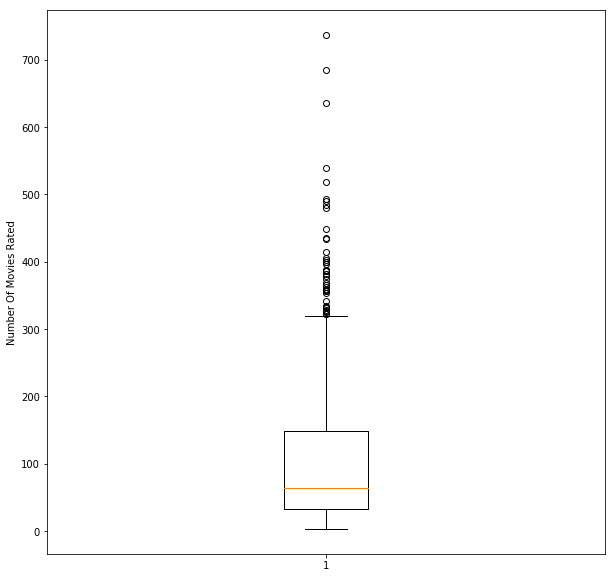

In [8]:
# Outlier Detection
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.boxplot(user_number_of_movies_rated['Number_of_Movies_Rated']) 
plt.ylabel('Number Of Movies Rated') 
plt.show()

From the above we can see that any user who has rated more than 320 movies rated can be considered as an outlier.
Now Let us identify those users and remove them from the data so they do not skew our correlation between the movies.

In [9]:
# Gives the list of user_id who have rated less than 320 movies
good_user_id = user_number_of_movies_rated.loc[user_number_of_movies_rated['Number_of_Movies_Rated'] < 320]['User_Id']
good_user_id.count()

902

In [10]:
# Selecting only the user id which have number of ratings less than 320
newratings = ratings[ratings['user_id'].isin(good_user_id)]
newratings.nunique()

movie_id    1577
title       1560
user_id      902
rating         5
dtype: int64

In [11]:
# Lets create a pivot table for the user-id and movie names which is easy to do item based collaborative filtering

userRatings = newratings.pivot_table(index=['user_id'], columns=['title'],values='rating')

userRatings.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,"World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,5.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# # Lets build a correlation matrix of the movies where we only compare against movies which have mean number of user ratings

# corrMatrix = userRatings.corr(method='pearson', min_periods=64)
# corrMatrix.head()

In [13]:
# # Lets us use the user id 0 as test just like in previous example. And use that to build recommendations for this user.

# myRatings = userRatings.loc[0].dropna()
# myRatings

In [14]:
# # Here using a log function for scaling
# simCandidates = pd.Series()
# for i in range(0, len(myRatings.index)):
#     print ("Adding sims for " + myRatings.index[i] + "...")
#     # Retrieve similar movies to this one that I rated
#     sims = corrMatrix[myRatings.index[i]].dropna()
#     # Now scale its similarity by how well I rated this movie # We are scaling this by a Square function which weights
#     # larger rating more than lower rating
#     sims = sims.map(lambda x: x * np.log10(myRatings[i]))
#     # Add the score to the list of similarity candidates
#     simCandidates = simCandidates.append(sims)
# #Glance at our results so far:
# print ("sorting...")
# simCandidates.sort_values(inplace = True, ascending = False)
# print (simCandidates.head(10))

In [15]:
# # Here using square function for scaling
# simCandidates = pd.Series()
# for i in range(0, len(myRatings.index)):
#     print ("Adding sims for " + myRatings.index[i] + "...")
#     # Retrieve similar movies to this one that I rated
#     sims = corrMatrix[myRatings.index[i]].dropna()
#     # Now scale its similarity by how well I rated this movie # We are scaling this by a Square function which weights
#     # larger rating more than lower rating
#     sims = sims.map(lambda x: x * myRatings[i] * myRatings[i])
#     # Add the score to the list of similarity candidates
#     simCandidates = simCandidates.append(sims)
# #Glance at our results so far:
# print ("sorting...")
# simCandidates.sort_values(inplace = True, ascending = False)
# print (simCandidates.head(10))

In [16]:
# # Here using square function and dividing by 25 for scaling
# simCandidates = pd.Series()
# for i in range(0, len(myRatings.index)):
#     print ("Adding sims for " + myRatings.index[i] + "...")
#     # Retrieve similar movies to this one that I rated
#     sims = corrMatrix[myRatings.index[i]].dropna()
#     # Now scale its similarity by how well I rated this movie # We are scaling this by a Square function which weights
#     # larger rating more than lower rating
#     sims = sims.map(lambda x: x * myRatings[i] * myRatings[i] / 25.0)
#     # Add the score to the list of similarity candidates
#     simCandidates = simCandidates.append(sims)
# #Glance at our results so far:
# print ("sorting...")
# simCandidates.sort_values(inplace = True, ascending = False)
# print (simCandidates.head(10))

In [17]:
# # using group by to combine rows and adding the weightage for each correlation
# simCandidates = simCandidates.groupby(simCandidates.index).sum()
# simCandidates.sort_values(inplace = True, ascending = False)
# simCandidates.head(10)

In [18]:
# # Removing the movies which were already rated
# filteredSims = simCandidates.drop(myRatings.index)
# filteredSims.head(10)

The results look lot better than 

In [32]:
def movierating(period,subject,scaling):
    corrMatrix = userRatings.corr(method='pearson', min_periods = period)
    myRatings = userRatings.loc[subject].dropna()
    if scaling == 1:
        simCandidates = pd.Series()
        for i in range(0, len(myRatings.index)):
            #print ("Adding sims for " + myRatings.index[i] + "...")
            # Retrieve similar movies to this one that I rated
            sims = corrMatrix[myRatings.index[i]].dropna()
            # Now scale its similarity by how well I rated this movie # We are scaling this by a Square function which weights
            # larger rating more than lower rating
            sims = sims.map(lambda x: x * np.log10(myRatings[i]))
            # Add the score to the list of similarity candidates
            simCandidates = simCandidates.append(sims)
        #Glance at our results so far:
#         print ("sorting...")
#         simCandidates.sort_values(inplace = True, ascending = False)
#         print (simCandidates.head(10))
    elif scaling == 2:
        # Here using square function for scaling
        simCandidates = pd.Series()
        for i in range(0, len(myRatings.index)):
            #print ("Adding sims for " + myRatings.index[i] + "...")
            # Retrieve similar movies to this one that I rated
            sims = corrMatrix[myRatings.index[i]].dropna()
            # Now scale its similarity by how well I rated this movie # We are scaling this by a Square function which weights
            # larger rating more than lower rating
            sims = sims.map(lambda x: x * myRatings[i] * myRatings[i])
            # Add the score to the list of similarity candidates
            simCandidates = simCandidates.append(sims)
        #Glance at our results so far:
#         print ("sorting...")
#         simCandidates.sort_values(inplace = True, ascending = False)
#         print (simCandidates.head(10))
    else :
        simCandidates = pd.Series()
        for i in range(0, len(myRatings.index)):
            #print ("Adding sims for " + myRatings.index[i] + "...")
            # Retrieve similar movies to this one that I rated
            sims = corrMatrix[myRatings.index[i]].dropna()
            # Now scale its similarity by how well I rated this movie # We are scaling this by a Square function which weights
            # larger rating more than lower rating
            sims = sims.map(lambda x: x * myRatings[i] * myRatings[i] / 25.0)
            # Add the score to the list of similarity candidates
            simCandidates = simCandidates.append(sims)
        #Glance at our results so far:
#         print ("sorting...")
#         simCandidates.sort_values(inplace = True, ascending = False)
#         print (simCandidates.head(10))
    simCandidates = simCandidates.groupby(simCandidates.index).sum()
    simCandidates.sort_values(inplace = True, ascending = False)
    filteredSims = simCandidates.drop(myRatings.index)
    return filteredSims.head(10)

movierating(25,0,1)

Return of the Jedi (1983)               0.989989
Raiders of the Lost Ark (1981)          0.757104
Mallrats (1995)                         0.720667
Giant (1956)                            0.594401
Delicatessen (1991)                     0.590083
Black Sheep (1996)                      0.580553
Bridge on the River Kwai, The (1957)    0.569521
Philadelphia Story, The (1940)          0.568714
Star Trek: Generations (1994)           0.567528
Con Air (1997)                          0.557203
dtype: float64